In [1]:
%%file mx_lenet_sagemaker.py
import logging
from os import path as op
import os

import mxnet as mx
import numpy as np

data_path = os.getcwd()+ "/"
batch_size = 50
num_cpus = 0
num_gpus = 1

def prep_data(data_path):
    """
    Convert numpy array to mx Nd-array.
    Parameters
    ----------
    path: the directory that save data.npz.
    """
    data = np.load(find_file(data_path, 'data.npz'))
    x_train = data['x_train']
    y_train = data['y_train'][:,:1] ## only take the second column of y_train
    x_test = data['x_test']
    y_test = data['y_test'][:,:1]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    img_mean = np.mean(x_train, axis=(0, 1, 2))
    img_std = np.std(x_train, axis=(0, 1, 2))
    
    x_train -= img_mean
    x_train /= img_std
    x_test -= img_mean
    x_test /= img_std

    img_rows = 256
    img_cols = 256

    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols) ## reshape it to (448, ) instead of (448,1)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    y_train = y_train.reshape(y_train.shape[0], )
    y_test = y_test.reshape(y_test.shape[0], )
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

    train_iter = mx.io.NDArrayIter(x_train, y_train, batch_size, shuffle=True)
    val_iter = mx.io.NDArrayIter(x_test, y_test, batch_size)

    return train_iter, val_iter

def find_file(root_path, file_name):
    """
    Searching for data.npz at its root director, and return a full path for the file.
    Parameters
    ----------
    root_path: the root directory for data.npz.
    file_name: refers to data.npz
    """
    for root, dirs, files in os.walk(root_path):
        if file_name in files:
            return os.path.join(root, file_name)

def mx_lenet():
    """Building a three layer LeNet sytle Convolutional Neural Net using MXNet."""
    data = mx.sym.var('data')
    data_dp = mx.symbol.Dropout(data, p = 0.2) ## 20% of the input that gets dropped out during training time
    # first conv layer
    conv1 = mx.sym.Convolution(data=data_dp, kernel=(5, 5), num_filter=20)
    tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
    pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2, 2), stride=(2, 2))
    # second conv layer
    conv2 = mx.sym.Convolution(data=pool1, kernel=(5, 5), num_filter=50)
    tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
    pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2, 2), stride=(2, 2))
    
    # third conv layer
    conv3 = mx.sym.Convolution(data=pool1, kernel=(5, 5), num_filter=50)
    tanh3 = mx.sym.Activation(data=conv2, act_type="tanh")
    pool3 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2, 2), stride=(2, 2))
    
    # first fullc layer
    flatten = mx.sym.flatten(data=pool3)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh4 = mx.sym.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.sym.FullyConnected(data=tanh4, num_hidden=2)
    # softmax loss
    return mx.sym.SoftmaxOutput(data=fc2, name='softmax')


def train(num_cpus, num_gpus, **kwargs):
    """
    Train the image classification neural net.
    Parameters
    ----------
    num_cpus: If train the model on an aws GPS machine, num_cpus = 0 and num_gpus = 1, vice versa.
    num_gpus: apply to the same rule above
    """
    train_iter, val_iter = prep_data(data_path)
    lenet = mx_lenet()
    lenet_model = mx.mod.Module(
        symbol=lenet,
        context=get_train_context(num_cpus, num_gpus))
    logging.getLogger().setLevel(logging.DEBUG)
    lenet_model.fit(train_iter,
                    eval_data=val_iter,
                    optimizer='sgd',
                    optimizer_params={'learning_rate': 0.1},
                    eval_metric='acc',
                    batch_end_callback=mx.callback.Speedometer(batch_size, 16),
                    num_epoch=100)
    return lenet_model


def get_train_context(num_cpus, num_gpus):
    """
    Define the model training instance.
    Parameters
    ----------
    num_cpus: If train the model on an aws GPS machine, num_cpus = 0 and num_gpus = 1, vice versa.
    num_gpus: apply to the same rule above
    """
    if num_gpus > 0:
        return mx.gpu()
    return mx.cpu()

def get_train_context(num_cpus, num_gpus):
    if num_gpus > 0:
        print("It's {} instance".format(num_gpus))
        return mx.gpu()
    print("It's {} instance".format(num_cpus))
    return mx.cpu()

Overwriting mx_lenet_sagemaker.py


In [2]:
%%time
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role

mxnet_estimator = MXNet("mx_lenet_sagemaker.py", 
                        role=get_execution_role(), 
                        train_instance_type="ml.p2.xlarge", 
                        train_instance_count=1)
mxnet_estimator.fit("s3://") ## give your s3 bucket URL here.

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-552819999234
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-gpu-2018-01-13-17-41-10-313


..................................................................................
executing startup script (first run)
2018-01-13 17:47:55,321 INFO - root - running container entrypoint
2018-01-13 17:47:55,321 INFO - root - starting train task
2018-01-13 17:47:56,932 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 1, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'mx_lenet_sagemaker.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'mx_lenet_sagemaker.py', u'sagemaker_submit_directory': u's3://

2018-01-13 17:50:15,106 INFO - root - Epoch[12] Validation-accuracy=0.508000
2018-01-13 17:50:18,196 INFO - root - Epoch[13] Batch [16]#011Speed: 265.04 samples/sec#011accuracy=0.532941
2018-01-13 17:50:21,228 INFO - root - Epoch[13] Batch [32]#011Speed: 263.90 samples/sec#011accuracy=0.515000
2018-01-13 17:50:21,984 INFO - root - Epoch[13] Train-accuracy=0.430000
2018-01-13 17:50:21,984 INFO - root - Epoch[13] Time cost=6.879
2018-01-13 17:50:24,029 INFO - root - Epoch[13] Validation-accuracy=0.556000
2018-01-13 17:50:27,110 INFO - root - Epoch[14] Batch [16]#011Speed: 265.77 samples/sec#011accuracy=0.540000
2018-01-13 17:50:30,139 INFO - root - Epoch[14] Batch [32]#011Speed: 264.19 samples/sec#011accuracy=0.520000
2018-01-13 17:50:30,893 INFO - root - Epoch[14] Train-accuracy=0.500000
2018-01-13 17:50:30,893 INFO - root - Epoch[14] Time cost=6.864
2018-01-13 17:50:32,925 INFO - root - Epoch[14] Validation-accuracy=0.578000
2018-01-13 17:50:36,002 INFO - root - Epoch[15] Batch [16]#01

2018-01-13 17:52:55,391 INFO - root - Epoch[30] Validation-accuracy=0.670000
2018-01-13 17:52:58,469 INFO - root - Epoch[31] Batch [16]#011Speed: 266.15 samples/sec#011accuracy=0.620000
2018-01-13 17:53:01,490 INFO - root - Epoch[31] Batch [32]#011Speed: 264.88 samples/sec#011accuracy=0.658750
2018-01-13 17:53:02,246 INFO - root - Epoch[31] Train-accuracy=0.520000
2018-01-13 17:53:02,246 INFO - root - Epoch[31] Time cost=6.854
2018-01-13 17:53:04,293 INFO - root - Epoch[31] Validation-accuracy=0.646000
2018-01-13 17:53:07,363 INFO - root - Epoch[32] Batch [16]#011Speed: 266.89 samples/sec#011accuracy=0.638824
2018-01-13 17:53:10,382 INFO - root - Epoch[32] Batch [32]#011Speed: 264.95 samples/sec#011accuracy=0.655000
2018-01-13 17:53:11,137 INFO - root - Epoch[32] Train-accuracy=0.725000
2018-01-13 17:53:11,138 INFO - root - Epoch[32] Time cost=6.844
2018-01-13 17:53:13,175 INFO - root - Epoch[32] Validation-accuracy=0.646000
2018-01-13 17:53:16,244 INFO - root - Epoch[33] Batch [16]#01

2018-01-13 17:55:35,553 INFO - root - Epoch[48] Validation-accuracy=0.618000
2018-01-13 17:55:38,619 INFO - root - Epoch[49] Batch [16]#011Speed: 267.18 samples/sec#011accuracy=0.622353
2018-01-13 17:55:41,627 INFO - root - Epoch[49] Batch [32]#011Speed: 265.93 samples/sec#011accuracy=0.667500
2018-01-13 17:55:42,382 INFO - root - Epoch[49] Train-accuracy=0.685000
2018-01-13 17:55:42,382 INFO - root - Epoch[49] Time cost=6.829
2018-01-13 17:55:44,415 INFO - root - Epoch[49] Validation-accuracy=0.654000
2018-01-13 17:55:47,477 INFO - root - Epoch[50] Batch [16]#011Speed: 267.56 samples/sec#011accuracy=0.651765
2018-01-13 17:55:50,488 INFO - root - Epoch[50] Batch [32]#011Speed: 265.68 samples/sec#011accuracy=0.695000
2018-01-13 17:55:51,242 INFO - root - Epoch[50] Train-accuracy=0.740000
2018-01-13 17:55:51,242 INFO - root - Epoch[50] Time cost=6.827
2018-01-13 17:55:53,280 INFO - root - Epoch[50] Validation-accuracy=0.634000
2018-01-13 17:55:56,352 INFO - root - Epoch[51] Batch [16]#01

2018-01-13 17:58:15,683 INFO - root - Epoch[66] Validation-accuracy=0.648000
2018-01-13 17:58:18,748 INFO - root - Epoch[67] Batch [16]#011Speed: 267.16 samples/sec#011accuracy=0.640000
2018-01-13 17:58:21,763 INFO - root - Epoch[67] Batch [32]#011Speed: 265.35 samples/sec#011accuracy=0.652500
2018-01-13 17:58:22,518 INFO - root - Epoch[67] Train-accuracy=0.745000
2018-01-13 17:58:22,518 INFO - root - Epoch[67] Time cost=6.835
2018-01-13 17:58:24,557 INFO - root - Epoch[67] Validation-accuracy=0.652000
2018-01-13 17:58:27,633 INFO - root - Epoch[68] Batch [16]#011Speed: 266.22 samples/sec#011accuracy=0.672941
2018-01-13 17:58:30,651 INFO - root - Epoch[68] Batch [32]#011Speed: 265.08 samples/sec#011accuracy=0.582500
2018-01-13 17:58:31,412 INFO - root - Epoch[68] Train-accuracy=0.670000
2018-01-13 17:58:31,412 INFO - root - Epoch[68] Time cost=6.854
2018-01-13 17:58:33,451 INFO - root - Epoch[68] Validation-accuracy=0.672000
2018-01-13 17:58:36,535 INFO - root - Epoch[69] Batch [16]#01

2018-01-13 18:00:55,772 INFO - root - Epoch[84] Validation-accuracy=0.688000
2018-01-13 18:00:58,858 INFO - root - Epoch[85] Batch [16]#011Speed: 265.41 samples/sec#011accuracy=0.738824
2018-01-13 18:01:01,895 INFO - root - Epoch[85] Batch [32]#011Speed: 263.49 samples/sec#011accuracy=0.713750
2018-01-13 18:01:02,656 INFO - root - Epoch[85] Train-accuracy=0.790000
2018-01-13 18:01:02,657 INFO - root - Epoch[85] Time cost=6.884
2018-01-13 18:01:04,711 INFO - root - Epoch[85] Validation-accuracy=0.674000
2018-01-13 18:01:07,803 INFO - root - Epoch[86] Batch [16]#011Speed: 264.92 samples/sec#011accuracy=0.718824
2018-01-13 18:01:10,839 INFO - root - Epoch[86] Batch [32]#011Speed: 263.50 samples/sec#011accuracy=0.710000
2018-01-13 18:01:11,599 INFO - root - Epoch[86] Train-accuracy=0.840000
2018-01-13 18:01:11,599 INFO - root - Epoch[86] Time cost=6.888
2018-01-13 18:01:13,640 INFO - root - Epoch[86] Validation-accuracy=0.680000
2018-01-13 18:01:16,724 INFO - root - Epoch[87] Batch [16]#01

In [12]:
%%time
predictor = mxnet_estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.p2.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-gpu-2018-01-13-17-41-10-313
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-gpu-2018-01-13-17-41-10-313


-------------------------------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 560 ms, sys: 44 ms, total: 604 ms
Wall time: 13min 20s


In [13]:
import numpy as np
import boto3
import botocore
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


def pred_img(bucket, img_s3, img_nn, image_mean, image_std):
    s3 = boto3.resource('s3')

    try:
        s3.Bucket(bucket).download_file(img_s3, img_nn)
        print("{} download under current directory".format(img_s3))
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
    img=Image.open(img_nn)
    img_np = np.array(img).astype('float32')
    # RBG chanels are between 0-255, so rescale it to be between 0-1.
    img_np /=255
    img_np -= image_mean
    img_np /= image_std
    #reshape the image to (1, 3, 256, 256) to pass to the predictor of MXNet Estimator
    img_np = img_np.reshape(1,img_np.shape[2],img_np.shape[0], img_np.shape[1]) 
    pred = predictor.predict(img_np)
    return pred

In [14]:
# replace with your bucket name
bucket = ''
# full path to the test image
img_s3 = 'MXNnet_example/data/103922-57564-17.jpg' 
# the new given name for the image you wanna save in current work directory
img_nn = "Image_1.jpg"

"""
Image mean and image_std are obtained from data.npz's by 
running img_mean = np.mean(x_train, axis=(0, 1, 2)), img_std = np.std(x_train, axis=(0, 1, 2))
"""
image_mean = np.array([ 0.14663778,  0.1624524 , -0.21313858]).astype('float32')
image_std = np.array([ 0.86569798,  0.77569193,  0.79192579]).astype('float32')

MX-Net/data/103922-57564-17.jpg download under current directory
The overall prediction is: [[5.465806793836236e-07, 0.9999994039535522]]
The tile cantain building(s)!


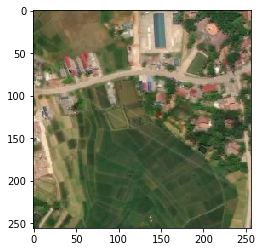

In [15]:
pred = pred_img(bucket, img_s3, img_nn, image_mean, image_std)
image_1 = plt.imread("Image_1.jpg")
plt.imshow(image_1)
print("The overall prediction is: {}".format(pred))
for item in pred:
    if item[0] > item[1]:
        print("It's background tile")
    else:
        print("The tile cantain building(s)!")